# 1.獲得関数の定義

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ncx2

def l2_lcb(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam = diff2 / gamma2
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    q = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    lower_bound = gamma2 * q
    return -lower_bound

def l2_ei(means, vars_, target, y_min, eps=1e-8):
    k = means.shape[1]
    gamma2 = np.maximum(vars_.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    nc = diff2 / gamma2
    x = y_min / gamma2
    t1 = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2 = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc) + nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

# 2.dfの準備

In [2]:
input = "/Users/macmini/Documents/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols = ["F12","F13","F14","F15","F16","F20","F0","R12","R13","R14","R15","R16","R20","R0"]
y_cols_m = ["mwave1", "mstrength1"]
y_cols_d = ["dwave1", "dstrength1"]

# 3.小・中・大規模データセット作成

In [8]:
s_ratio = 0.01
# m_ratio = 0.3
l_ratio = 0.99
df_small = df_all.sample(frac=s_ratio, random_state=0)
# df_medium = df_all.sample(frac=m_ratio, random_state=0)
df_large = df_all.sample(frac=l_ratio, random_state=0)

df_small = df_small.reset_index(drop=True)
# df_medium = df_medium.reset_index(drop=True)
df_large = df_large.reset_index(drop=True)

print(f"Small dataset size: {df_small.shape[0]}")
# print(f"Medium dataset size: {df_medium.shape[0]}")
print(f"Large dataset size: {df_large.shape[0]}")

Small dataset size: 3
Large dataset size: 253


# 4.網羅的探索関数の定義

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-LCB acquisition: returns -lower_bound (larger → more exploratory)
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam   = diff2 / gamma2
    q     = ncx2.ppf(1 - p, df=k, nc=lam)
    q     = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement acquisition
    """
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """
    Train independent GPRegression (Matern52 ARD) for each output.
    """
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=False)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """
    Returns (means, variances) both shape (n_samples, n_outputs).
    """
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def active_learning_loocv_on_acquired(
    train_df: pd.DataFrame,
    cand_df: pd.DataFrame,
    X_cols: list,
    Y_cols: list,
    target: np.ndarray,
    acquisition: str = 'lcb',
    p: float = 0.05,
    budget: int = None,
    skip_initial: int = 10,
    seed: int = 0
) -> pd.DataFrame:
    """
    Active learning + LOOCV R² on acquired samples.
    ① 再現性: seedでRNG固定
    ② 各目的ごとのR²を multioutput='raw_values' で取得
    """
    # データコピー＆reset
    train_df = train_df.copy().reset_index(drop=True)
    cand_df  = cand_df.copy().reset_index(drop=True)
    acquired_df = pd.DataFrame(columns=train_df.columns)

    # RNG初期化
    rng = np.random.RandomState(seed)

    n_iter = budget if budget is not None else len(cand_df)
    n_obj  = len(Y_cols)
    loocv_r2_list = []

    for it in range(1, n_iter + 1):
        # 学習データでGPフィット
        Xtr = train_df[X_cols].values
        Ytr = train_df[Y_cols].values
        scl = StandardScaler().fit(Ytr)
        Ytr_s = scl.transform(Ytr)
        tgt_s  = scl.transform(target.reshape(1, -1)).flatten()

        models = fit_multi_gpy(Xtr, Ytr_s)
        Xcand, _ = cand_df[X_cols].values, None
        mus, vars_ = predict_multi_gpy(models, Xcand)

        if acquisition == 'lcb':
            scores = l2_lcb_exact(mus, vars_, tgt_s, p)
        elif acquisition == 'ei':
            y_min  = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
            scores = l2_ei(mus, vars_, tgt_s, y_min)
        else:  # 'rand'
            scores = rng.rand(len(cand_df))

        # 次点選択・追加
        idx_pick   = int(np.argmax(scores))
        new_sample = cand_df.iloc[[idx_pick]]
        cand_df = cand_df.drop(cand_df.index[idx_pick]).reset_index(drop=True)
        acquired_df = pd.concat([acquired_df, new_sample], ignore_index=True)
        train_df    = pd.concat([train_df, new_sample], ignore_index=True)

        # LOOCV R²
        if len(acquired_df) <= skip_initial:
            loocv_r2_list.append([np.nan] * n_obj)
            continue

        y_true_list, y_pred_list = [], []
        for j in range(len(acquired_df)):
            df_loo = acquired_df.drop(index=j).reset_index(drop=True)
            X_loo  = df_loo[X_cols].values
            Y_loo  = df_loo[Y_cols].values
            scl_loo= StandardScaler().fit(Y_loo)
            Y_loo_s= scl_loo.transform(Y_loo)

            models_loo = fit_multi_gpy(X_loo, Y_loo_s)
            x_test     = acquired_df.iloc[[j]][X_cols].values
            mu_s, _    = predict_multi_gpy(models_loo, x_test)
            mu_orig    = scl_loo.inverse_transform(mu_s).flatten()

            y_true_list.append(acquired_df.iloc[j][Y_cols].values)
            y_pred_list.append(mu_orig)

        Y_true_all = np.vstack(y_true_list)
        Y_pred_all = np.vstack(y_pred_list)
        # 各出力ごとのR²を返す
        r2_arr = r2_score(Y_true_all, Y_pred_all, multioutput='raw_values')
        loocv_r2_list.append(r2_arr)

    # DataFrame化
    df_loocv = pd.DataFrame(
        np.vstack(loocv_r2_list),
        columns=Y_cols,
        index=np.arange(1, n_iter + 1)
    )
    return df_loocv

def plot_acquired_loocv(df_loocv: pd.DataFrame):
    """
    各目的関数ごとに折れ線プロット
    """
    for col in df_loocv.columns:
        plt.figure(figsize=(6,4))
        plt.plot(df_loocv.index, df_loocv[col], marker='o')
        plt.xlabel("Iteration")
        plt.ylabel(f"LOOCV R² ({col})")
        plt.title(f"LOOCV R² on Acquired: {col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- 使用例 ---
# df_loocv = active_learning_loocv_on_acquired(
#     train_df     = df_small,
#     cand_df      = df_medium,
#     X_cols       = X_cols,
#     Y_cols       = Y_cols,
#     target       = np.array([330.64, 0.5]),
#     acquisition  = 'lcb',
#     p            = 0.7,
#     budget       = 100,
#     skip_initial = 10,
#     seed         = 42
# )
# plot_acquired_loocv(df_loocv)


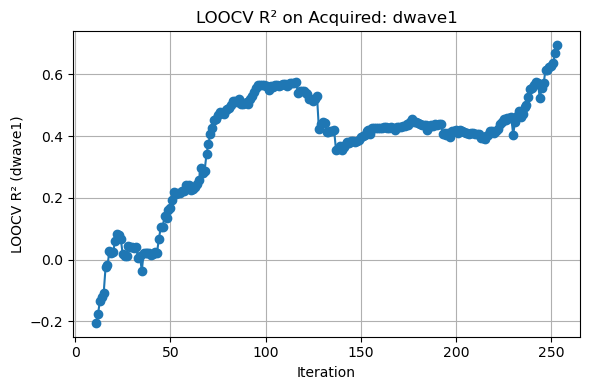

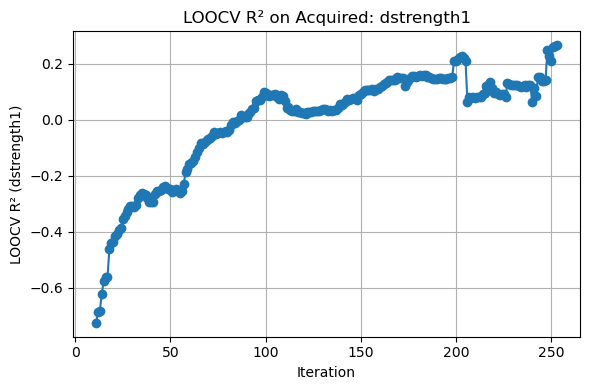

In [10]:
import pandas as pd
import numpy as np

# --- １．データ読み込み（例として Excel） ---


# --- ２．特徴量・目的変数・ターゲット定義 ---
X_cols = ["F12","F13","F14","F15","F16","F20","F0",
          "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])
# --- ３．LOOCV付きアクティブラーニング実行 ---
#   skip_initial: 最初の n 点は LOOCV 計算をスキップ
#   seed: 乱数シード（再現性確保）
df_loocv = active_learning_loocv_on_acquired(
    train_df        = df_small,  # 小データを学習用に使用
    cand_df         = df_large,  # 中データを候補プールに使用
    X_cols          = X_cols,
    Y_cols          = Y_cols,
    target          = target,
    acquisition     = 'lcb',      # 'lcb' or 'ei' or 'rand'
    p               = 0.7,        # LCB の信頼度パラメータ
    budget          = 253,        # 最大取得回数
    skip_initial    = 10,         # LOOCV 開始までの取得数
    seed            = 42          # 再現性のための乱数シード
)

# df_loocv は DataFrame:
#      iteration | mwave1 | mstrength1
#      -----------------------------
#           1     |   NaN  |    NaN       ← skip_initial 以下は NaN
#         2…10    |   NaN  |    NaN
#         11      |  0.x   |    0.y
#         …       |  …     |    …

# --- ４．結果プロット ---
plot_acquired_loocv(df_loocv)


# FP 

In [12]:
FP_file = "/Users/macmini/Documents/多目的最適化の理論構築/FP_BO.ipynb/fp.csv"
df_fp = pd.read_csv(FP_file)
df_all_FP = pd.concat([df_all, df_fp], axis=1)
df_small_FP = df_all_FP.sample(frac=s_ratio, random_state=0)
df_large_FP = df_all_FP.sample(frac=l_ratio, random_state=0)
# df_FPの1しかないカラムを抜く
# ユニーク値の種類数が「1より大きい」カラムだけを残す
df_FP_NONE1 = df_fp.loc[:, df_fp.nunique(dropna=False) > 1]

# カラム名リスト
X_cols_FP_NONE1 = df_FP_NONE1.columns.tolist()
print(f"FP columns with more than one unique value: {len(X_cols_FP_NONE1)}")

FP columns with more than one unique value: 189


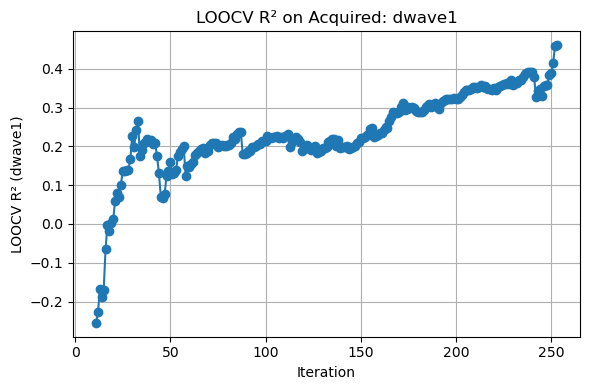

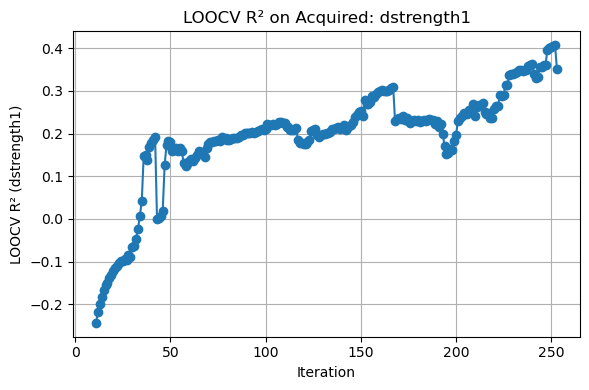

In [13]:
df_loocv_FP = active_learning_loocv_on_acquired(
    train_df        = df_small_FP,  # 小データを学習用に使用
    cand_df         = df_large_FP,  # 中データを候補プールに使用
    X_cols          = X_cols_FP_NONE1,
    Y_cols          = Y_cols,
    target          = target,
    acquisition     = 'lcb',      # 'lcb' or 'ei' or 'rand'
    p               = 0.7,        # LCB の信頼度パラメータ
    budget          = 253,        # 最大取得回数
    skip_initial    = 10,         # LOOCV 開始までの取得数
    seed            = 42          # 再現性のための乱数シード
)

# df_loocv は DataFrame:
#      iteration | mwave1 | mstrength1
#      -----------------------------
#           1     |   NaN  |    NaN       ← skip_initial 以下は NaN
#         2…10    |   NaN  |    NaN
#         11      |  0.x   |    0.y
#         …       |  …     |    …

# --- ４．結果プロット ---
plot_acquired_loocv(df_loocv_FP)